# Préparation de l'environnement

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

# Téléchargement des mots inutiles en français
nltk.download('stopwords')
stop_words_fr = stopwords.words('french')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FRANCKI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Chargement et Nettoyage

In [62]:
# Remplace 'ton_fichier.csv' par le nom de ton dataset
df = pd.read_csv('Dataset/data-en-hi-de-fr.csv', encoding='latin-1')
df = df[['labels', 'text_fr']]
df.columns = ['label', 'message']

# Encodage : ham -> 0, spam -> 1
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)

print(df)

      label                                            message
0         0  Allez jusqu'Ã  Jurong point, fou.. Disponible ...
1         0           J'ai fait une blague sur le wif u oni...
2         1  EntrÃ©e libre dans 2 a wkly comp pour gagner F...
3         0  U dun dit si tÃ´t hor... U c dÃ©jÃ  dire alors...
4         0  Non, je ne pense pas qu'il va Ã  usf, il vit d...
...     ...                                                ...
5567      1  C'est la 2Ã¨me fois que nous avons essayÃ© 2 c...
5568      0      Est-ce que Ã¼ b ira Ã  l'esplanade en maison?
5569      0  Dommage, * Ã©tait d'humeur pour Ã§a. Donc... d...
5570      0  Le type a fait une saloperie mais j'ai agi com...
5571      0                        Rofl. C'est vrai Ã  son nom

[5572 rows x 2 columns]


# Construction et Entraînement du Pipeline

In [64]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words=stop_words_fr, 
        ngram_range=(1, 2),
        min_df=2,        # Ignore les mots qui n'apparaissent que dans 1 seul message
        max_df=0.8       # Ignore les mots présents dans plus de 80% des messages (trop communs)
    )),
    ('nb', MultinomialNB(alpha=1.0)) # alpha=1.0 est le lissage par défaut
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, min_df=2, ngram_range=(1, 2),
                                 stop_words=['au', 'aux', 'avec', 'ce', 'ces',
                                             'dans', 'de', 'des', 'du', 'elle',
                                             'en', 'et', 'eux', 'il', 'ils',
                                             'je', 'la', 'le', 'les', 'leur',
                                             'lui', 'ma', 'mais', 'me', 'même',
                                             'mes', 'moi', 'mon', 'ne', 'nos', ...])),
                ('nb', MultinomialNB())])

# Création de la Matrice de Confusion

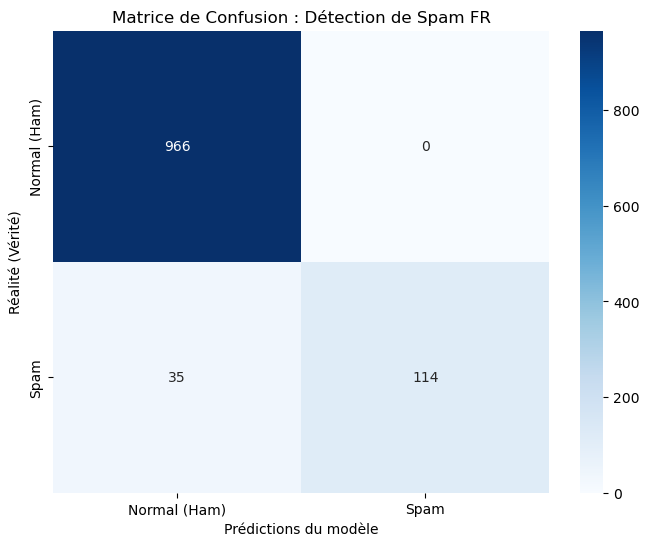

In [67]:
# 1. Faire des prédictions
y_pred = pipeline.predict(X_test)

# 2. Calculer la matrice
cm = confusion_matrix(y_test, y_pred)

# 3. Affichage graphique avec Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal (Ham)', 'Spam'], 
            yticklabels=['Normal (Ham)', 'Spam'])
plt.xlabel('Prédictions du modèle')
plt.ylabel('Réalité (Vérité)')
plt.title('Matrice de Confusion : Détection de Spam FR')
plt.show()

# Analyse des erreurs spécifiques

In [70]:
# Créer un DataFrame pour comparer
resultats = pd.DataFrame({'Message': X_test, 'Réel': y_test, 'Prédit': y_pred})

# Afficher les "Faux Positifs" (Messages normaux classés comme Spam)
faux_positifs = resultats[(resultats['Réel'] == 0) & (resultats['Prédit'] == 1)]
print("Messages normaux confondus avec des spams :")
print(faux_positifs['Message'].head())

# Afficher les "Faux Négatifs" (Spams non détectés)
faux_negatifs = resultats[(resultats['Réel'] == 1) & (resultats['Prédit'] == 0)]
print("\nSpams non détectés par le modèle :")
print(faux_negatifs['Message'].head())

Messages normaux confondus avec des spams :
Series([], Name: Message, dtype: object)

Spams non détectés par le modèle :
881     Rappel: Vous n'avez pas tÃ©lÃ©chargÃ© le conte...
1961    Devinez quoi! Quelqu'un que vous connaissez se...
3864    Oh mon dieu, j'ai retrouvÃ© ton numÃ©ro, je su...
2575    Votre prochaine vidÃ©o incroyable xxx PICSFREE...
3548    Rock yr chik. Obtenez 100's de films sales & X...
Name: Message, dtype: object


# Entrainement

In [75]:
# --- ÉTAPE D'ENTRAÎNEMENT ---
pipeline.fit(X_train, y_train)

def predict_with_threshold(messages, model, threshold=0.85):
    # On récupère les probabilités pour la classe 1 (Spam)
    probs = model.predict_proba(messages)[:, 1]
    # On applique le seuil strict
    return (probs >= threshold).astype(int)

# Application sur le jeu de test pour validation
y_pred_custom = predict_with_threshold(X_test, pipeline, threshold=0.85)

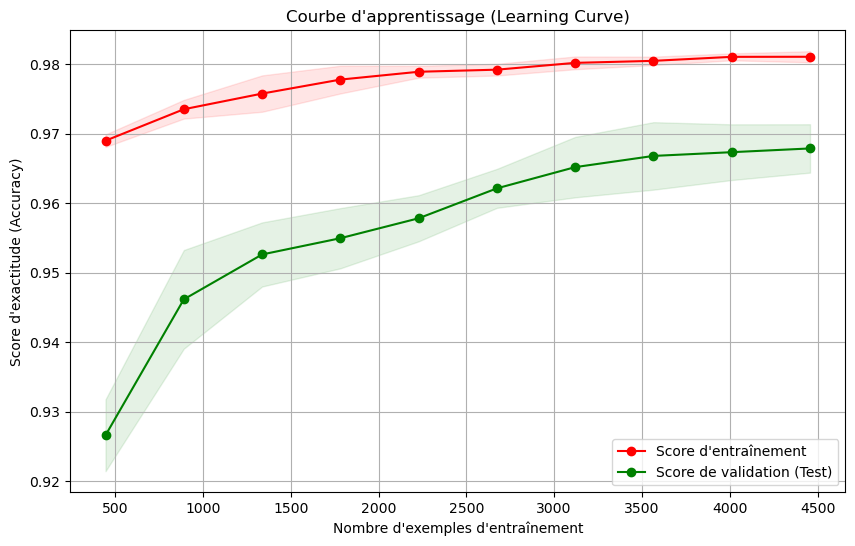

In [77]:
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    # Calcul des moyennes et écarts-types
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Tracé du graphique
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Score d'entraînement")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Score de validation (Test)")

    # Affichage de l'incertitude (optionnel)
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.title("Courbe d'apprentissage (Learning Curve)")
    plt.xlabel("Nombre d'exemples d'entraînement")
    plt.ylabel("Score d'exactitude (Accuracy)")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Appel de la fonction avec ton pipeline et tes données complètes
plot_learning_curve(pipeline, df['message'], df['label'])

In [79]:
def test_detecteur(phrase, seuil=0.85):
    # Calcul de la probabilité
    proba_spam = pipeline.predict_proba([phrase])[0][1]
    
    # Décision selon le seuil
    statut = "🚨 SPAM" if proba_spam >= seuil else "✅ MESSAGE NORMAL"
    
    print(f"Message : {phrase}")
    print(f"Confiance Spam : {proba_spam:.2%}")
    print(f"Résultat : {statut}")
    print("-" * 30)

# TESTS
test_detecteur("Salut, tu viens manger à la maison ce soir ?") 
test_detecteur("FÉLICITATIONS ! Vous avez gagné 1000€, cliquez ici vite !!!")
test_detecteur("Votre colis est disponible, payez les frais de port maintenant.")
test_detecteur("Call Congratulations! You've won a $1000 gift card.  now to claim.")

Message : Salut, tu viens manger à la maison ce soir ?
Confiance Spam : 0.24%
Résultat : ✅ MESSAGE NORMAL
------------------------------
Message : FÉLICITATIONS ! Vous avez gagné 1000€, cliquez ici vite !!!
Confiance Spam : 12.52%
Résultat : ✅ MESSAGE NORMAL
------------------------------
Message : Votre colis est disponible, payez les frais de port maintenant.
Confiance Spam : 7.86%
Résultat : ✅ MESSAGE NORMAL
------------------------------
Message : Call Congratulations! You've won a $1000 gift card.  now to claim.
Confiance Spam : 81.18%
Résultat : ✅ MESSAGE NORMAL
------------------------------


In [81]:
import joblib

# Sauvegarde du pipeline complet (TF-IDF + Naive Bayes)
joblib.dump(pipeline, 'detecteur_spam.pkl')

print("Modèle exporté avec succès sous le nom 'detecteur_spam.pkl'")

Modèle exporté avec succès sous le nom 'detecteur_spam.pkl'
